# textual embedding LLM

In [1]:
import os
import torch 
from PIL import Image
from transformers import pipeline
from transformers import AutoTokenizer, AutoModel
import argparse
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from torch import Tensor
from scipy.stats import norm
import torch
import clip
from PIL import Image


In [2]:
def plot_dis(data, title):
    # 示例数据：22x22 的随机矩阵
    # 将数据展平为一维数组
    flat_data = data.flatten()
    
    # 绘制数据密度分布曲线
    plt.figure(figsize=(8, 6))
    sns.kdeplot(flat_data, color='deepskyblue', fill=True, thresh=0.05, linewidth=1)
    plt.xlabel('Value', fontsize=14)
    plt.xlim(0,1)
    plt.ylabel('Density', fontsize=14)
    plt.title(f'Similarity distribution in {title}', fontsize=16)
    plt.grid(True)
    plt.show()
    # fig.savefig(f'{title}_distribution', dpi=300, bbox_inches='tight')

In [3]:
NIH = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema','Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

CheXpert = [ 'Atelectasis','Cardiomegaly','Consolidation','Edema','Enlarged Cardiomediastinum',
 'Fracture','Lung Lesion','Lung Opacity','Pleural Effusion','Pleural Other','Pneumonia',
 'Pneumothorax',"Support Devices"]

NIH_prompt = [f"it is a images of {i}" for i in NIH]
CheXpert_prompt = [f"it is a images of {i}" for i in CheXpert]
NIH = set(NIH)
CheXpert = set(CheXpert)
text = NIH.union(CheXpert)
text_raw  = list(text)
text_4_clip = [f"it is a image of {i}" for i in text]
print(text_4_clip)


['it is a image of Emphysema', 'it is a image of Mass', 'it is a image of Pneumonia', 'it is a image of Fracture', 'it is a image of Lung Lesion', 'it is a image of Lung Opacity', 'it is a image of Fibrosis', 'it is a image of Edema', 'it is a image of Atelectasis', 'it is a image of Support Devices', 'it is a image of Pleural Effusion', 'it is a image of Hernia', 'it is a image of Effusion', 'it is a image of Pneumothorax', 'it is a image of Enlarged Cardiomediastinum', 'it is a image of Pleural Other', 'it is a image of Cardiomegaly', 'it is a image of Consolidation', 'it is a image of Nodule', 'it is a image of Pleural_Thickening', 'it is a image of Infiltration']


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
# sns.reset_defaults()
def plot_heat(cosine_sim_matrix, title, with_line=False):
    # 设置 Seaborn 样式
    sns.set(style="whitegrid", font_scale=1.2)
    
    # 创建图形
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # 绘制热度图，不显示数字，设置颜色条的范围为 0.8 到 1
    if with_line:
        heatmap = sns.heatmap(cosine_sim_matrix, annot=False, cmap='coolwarm', vmin=0., vmax=1,linewidths=0.5,cbar=True, 
                          cbar_kws={'label': 'Cosine Similarity'}, ax=ax)
    else:
        heatmap = sns.heatmap(cosine_sim_matrix, annot=False, cmap='coolwarm', vmin=0., vmax=1, 
                          cbar_kws={'label': 'Cosine Similarity'}, ax=ax)
    
    # 设置标题和轴标签
    ax.set_title(f"Cosine Similarity Heatmap in {title}", fontsize=20, )
    ax.set_xlabel('Sentence Index', fontsize=15, )
    ax.set_ylabel('Sentence Index', fontsize=15,)
    
    # 设置刻度标签的字体大小
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # 调整颜色条的标签字体大小
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Cosine Similarity', size=15, )
    
    # 显示图形
    plt.tight_layout()
    plt.show()
    
    # 保存图形为高分辨率图像
    fig.savefig(f'{title}_cosine_similarity_heatmap.png', dpi=300, bbox_inches='tight')

## CLIP

In [5]:
!export CUDA_LAUNCH_BLOCKING=1


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

text = clip.tokenize(text_4_clip).to(device)
text_embeddings = model.encode_text(text)
text_embeddings.shape


NIH_embedding = clip.tokenize(NIH_prompt).to(device)
NIH_CLIP_embedding = model.encode_text(NIH_embedding)

CheXpert_embedding = clip.tokenize(CheXpert_prompt).to(device)
CheXpert_CLIP_embedding = model.encode_text(CheXpert_embedding)



In [7]:
print(f"the shape of CheXpert_CLIP_embedding: {CheXpert_CLIP_embedding.shape}")
print(f"the shape of NIH_CLIP_embedding: {NIH_CLIP_embedding.shape}")

the shape of CheXpert_CLIP_embedding: torch.Size([13, 512])
the shape of NIH_CLIP_embedding: torch.Size([14, 512])


In [8]:
cosine_sim_matrix = cosine_similarity(text_embeddings.detach().cpu().numpy() )
CLIP = cosine_sim_matrix.flatten()
CLIP.shape

(441,)

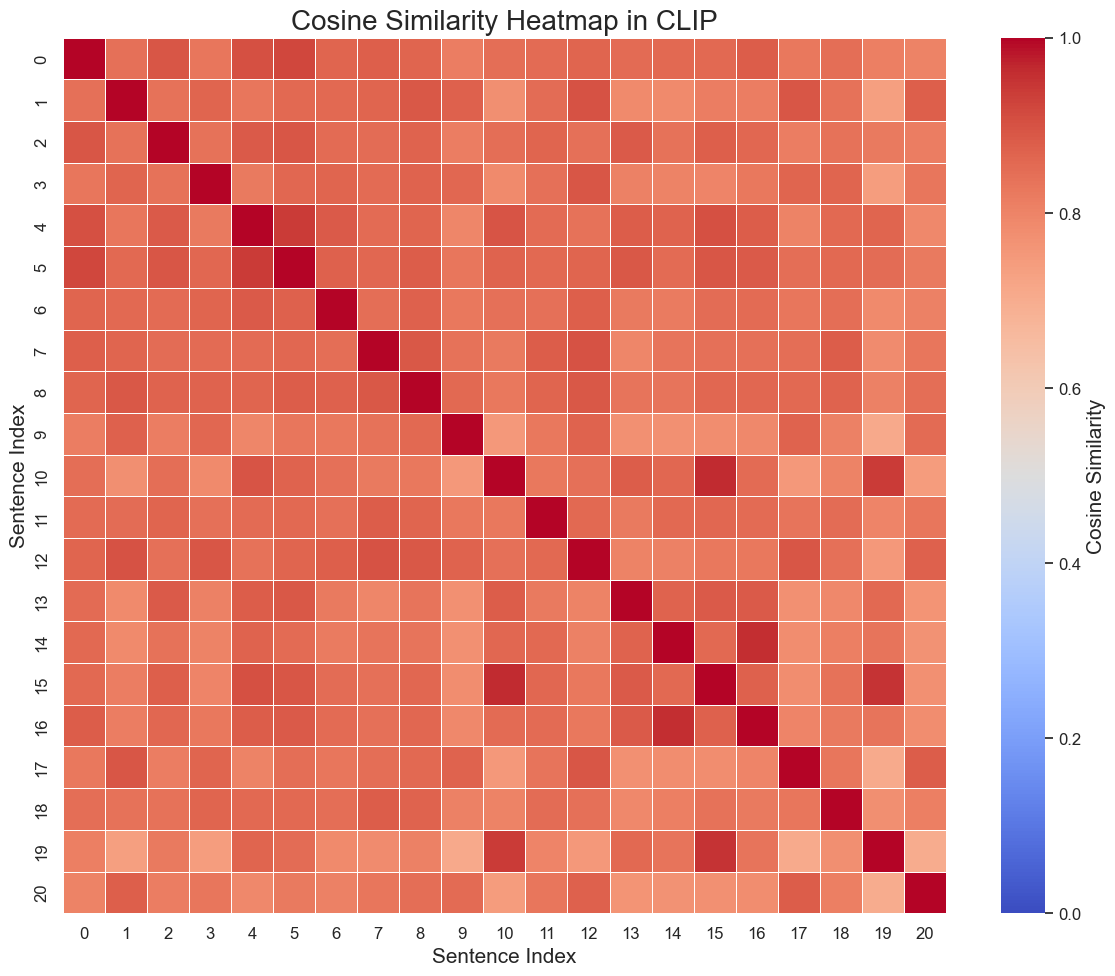

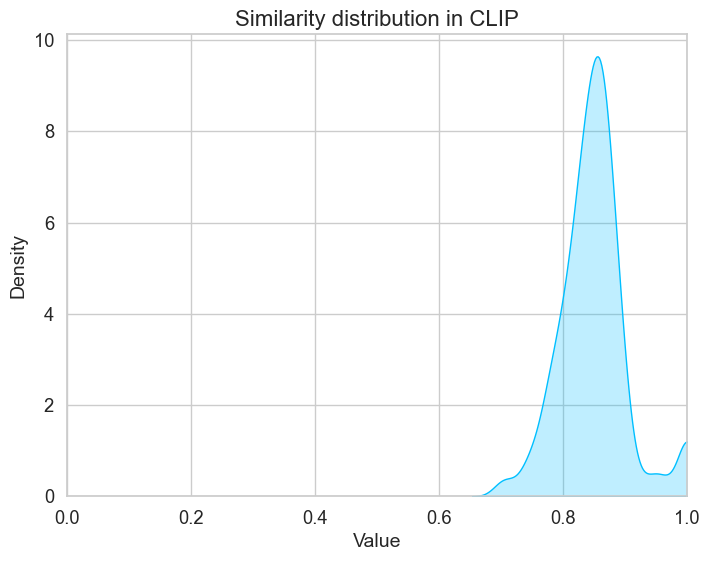

In [9]:
plot_heat(cosine_sim_matrix, "CLIP", True)
plot_dis(cosine_sim_matrix, "CLIP")

## BiomedCLIP

BiomedCLIP is a biomedical vision-language foundation model that is pretrained on **PMC-15M, a dataset of 15 million figure-caption pairs extracted from biomedical research articles in PubMed Central**, using contrastive learning. It uses PubMedBERT as the text encoder and Vision Transformer as the image encoder, with domain-specific adaptations. It can perform various vision-language processing (VLP) tasks such as cross-modal retrieval, image classification, and visual question answering. BiomedCLIP establishes new state of the art in a wide range of standard datasets, and substantially outperforms prior VLP approaches:

In [10]:
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8
import torch
from PIL import Image
model, preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()

context_length = 256
img = r"./CLIP_cosine_similarity_heatmap.png"
dummy_img = torch.stack([preprocess(Image.open(img))]).to(device)
texts = tokenizer(text_4_clip).to(device)
with torch.no_grad():
    image_features, text_features, logit_scale = model(dummy_img, texts)


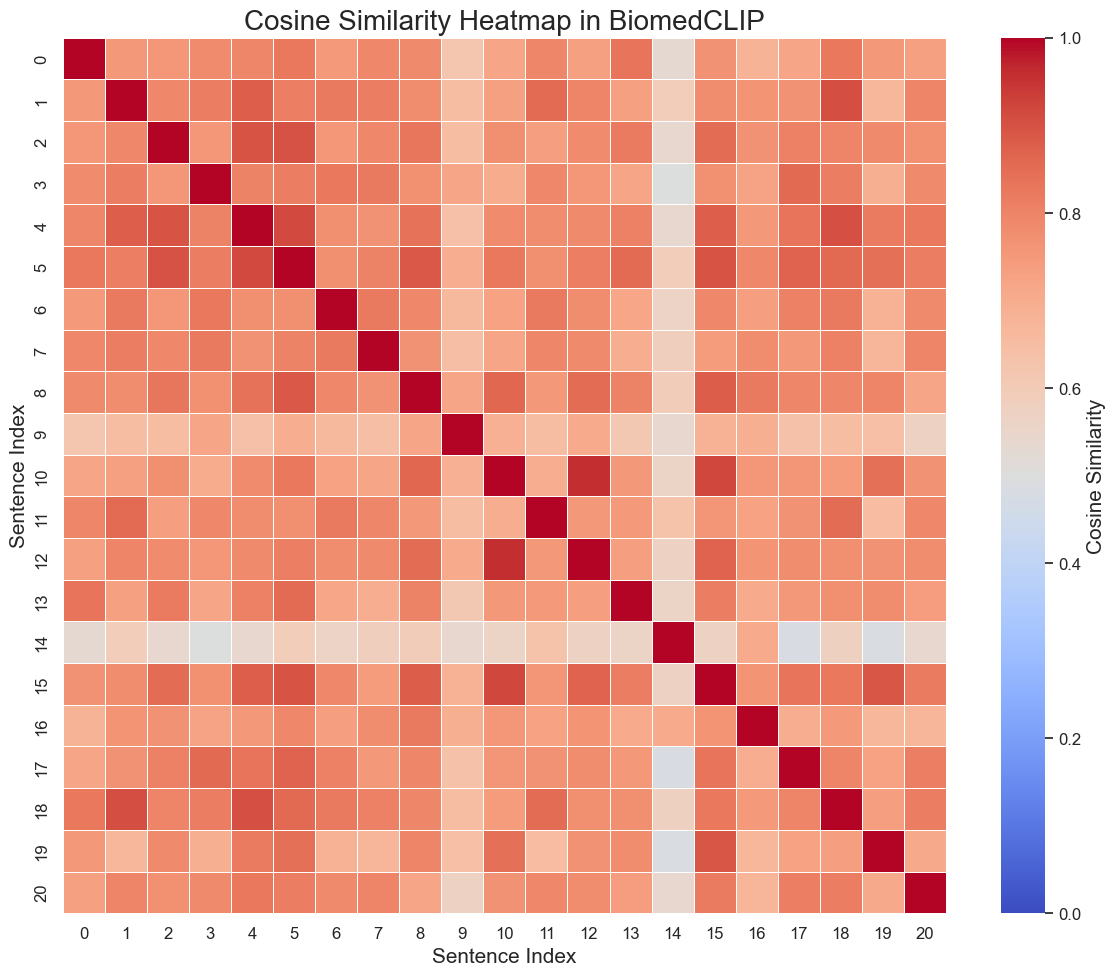

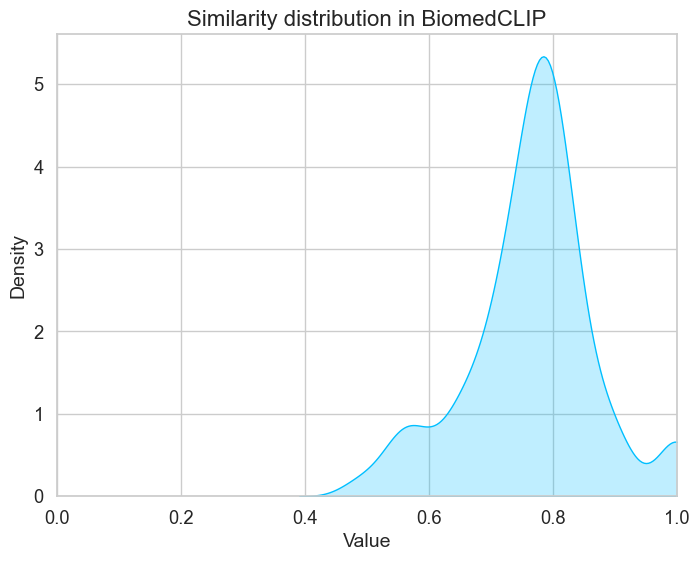

In [11]:
cosine_sim_matrix = cosine_similarity(text_features.detach().cpu().numpy() )
plot_heat(cosine_sim_matrix, "BiomedCLIP", with_line=True)
plot_dis(cosine_sim_matrix, "BiomedCLIP")
BiomedCLIP = cosine_sim_matrix.flatten()


In [12]:
model, preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# model.to(device)
model.eval()

context_length = 256
img = r"./CLIP_cosine_similarity_heatmap.png"
dummy_img = torch.stack([preprocess(Image.open(img))])#.to(device)

texts = tokenizer(NIH_prompt)#.to(device)
with torch.no_grad():
    image_features, NIH_BiomedCLIP_embedding, logit_scale = model(dummy_img, texts)
    
texts = tokenizer(CheXpert_prompt)#.to(device)
with torch.no_grad():
    image_features, CheXpert_BiomedCLIP_embedding, logit_scale = model(dummy_img, texts)

In [13]:
CheXpert_CLIP_embedding.shape

torch.Size([13, 512])

In [14]:
NIH_BiomedCLIP_embedding.shape

torch.Size([14, 512])

## CXR-BERT-general 

Some weights of the model checkpoint at microsoft/BiomedVLP-CXR-BERT-general were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


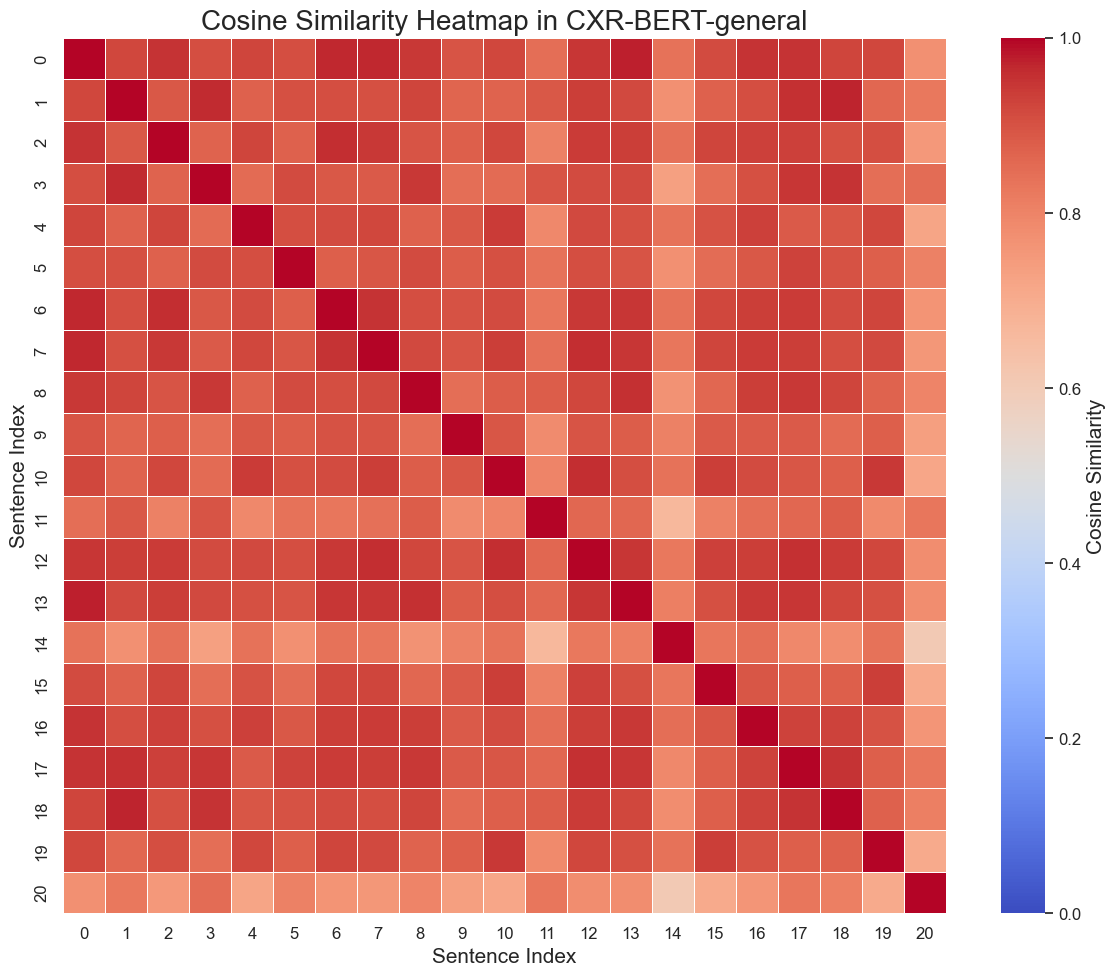

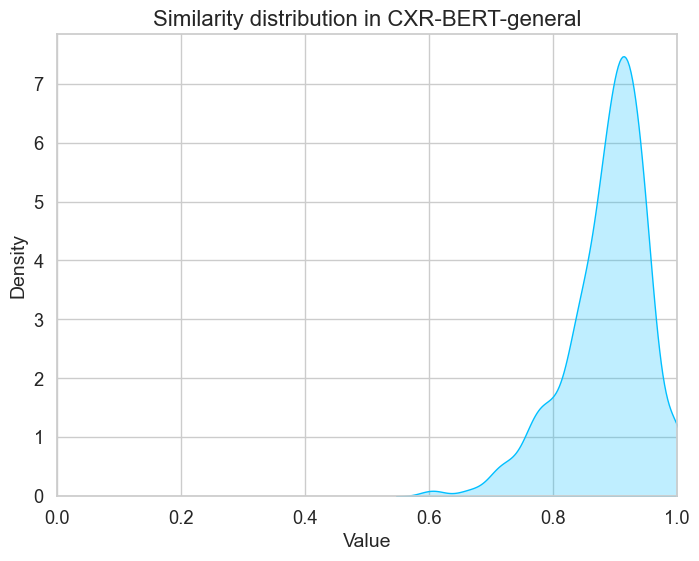

In [15]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedVLP-CXR-BERT-general")
model = AutoModelForMaskedLM.from_pretrained("microsoft/BiomedVLP-CXR-BERT-general")
with torch.no_grad():
  encoded_input = tokenizer(text_4_clip, return_tensors='pt', padding=True, )
  output = model(**encoded_input, output_hidden_states=True)
del encoded_input
del model
del tokenizer
avg_embedding = torch.mean(output.hidden_states[-1], axis=1)
del output

avg_embedding
cosine_sim_matrix = cosine_similarity(avg_embedding.detach().cpu().numpy())
plot_heat(cosine_sim_matrix, "CXR-BERT-general",True)
plot_dis(cosine_sim_matrix, "CXR-BERT-general")

CXR_Bert_general = cosine_sim_matrix.flatten()

## CXR-BERT-specialized (after multi-modal training)

In [16]:
from transformers import BertModel, BertTokenizer
import torch

# 加载BERT模型和tokenizer
model_name = "microsoft/BiomedVLP-CXR-BERT-specialized"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# 定义输入文本列表
text_list = text_4_clip
# 使用tokenizer对文本进行处理，确保扁平化的输入列表
inputs = tokenizer(text_list, padding=True, truncation=True, return_tensors="pt")

# 推理模型，获取输出
with torch.no_grad():
    outputs = model(**inputs)

# 提取CLS token的输出作为句子的embedding表示
cls_embeddings = outputs.last_hidden_state[:, 0, :]

# 打印每个句子的embedding表示
for i, embedding in enumerate(cls_embeddings):
    print(f"Embedding for sentence {i+1}:")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'CXRBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type cxr-bert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertModel were not initialized from the model checkpoint at microsoft/BiomedVLP-CXR-BERT-specialized and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Embedding for sentence 1:
Embedding for sentence 2:
Embedding for sentence 3:
Embedding for sentence 4:
Embedding for sentence 5:
Embedding for sentence 6:
Embedding for sentence 7:
Embedding for sentence 8:
Embedding for sentence 9:
Embedding for sentence 10:
Embedding for sentence 11:
Embedding for sentence 12:
Embedding for sentence 13:
Embedding for sentence 14:
Embedding for sentence 15:
Embedding for sentence 16:
Embedding for sentence 17:
Embedding for sentence 18:
Embedding for sentence 19:
Embedding for sentence 20:
Embedding for sentence 21:


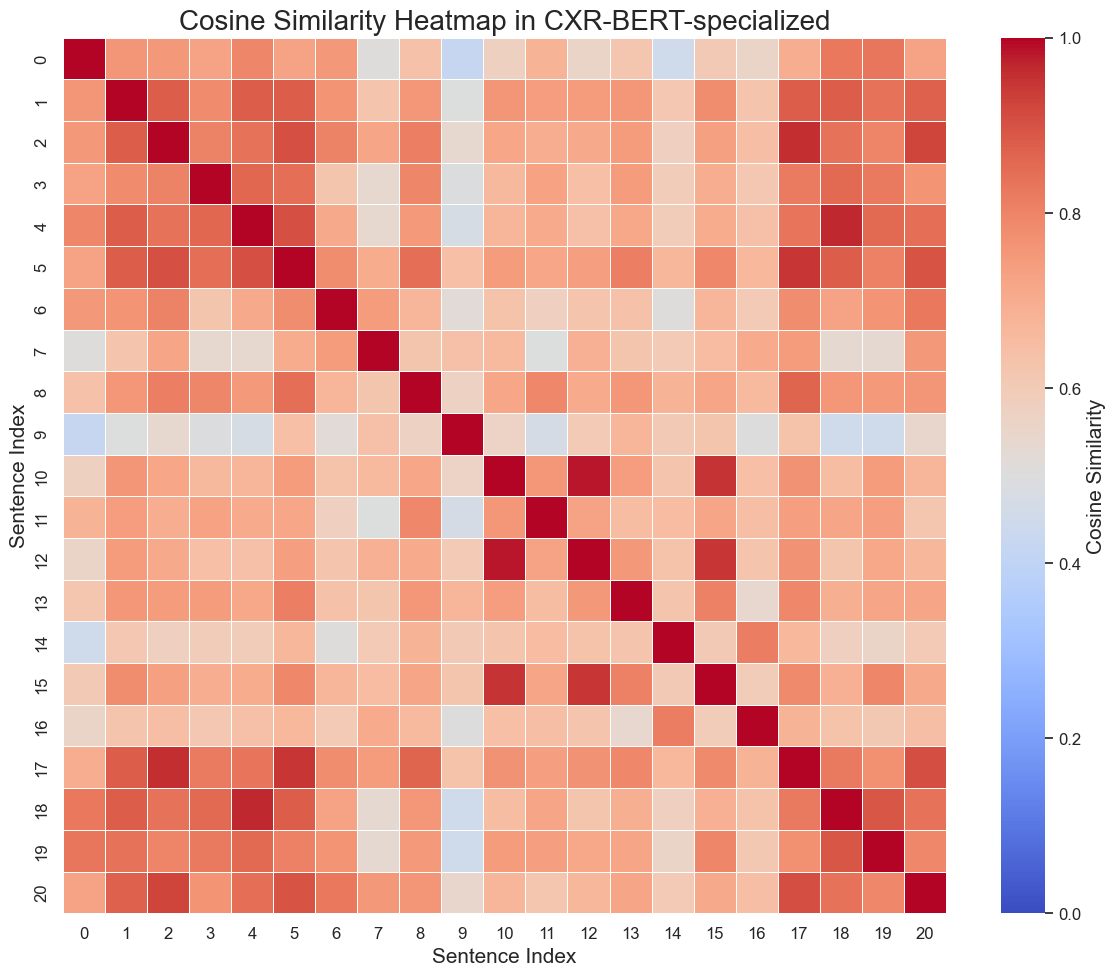

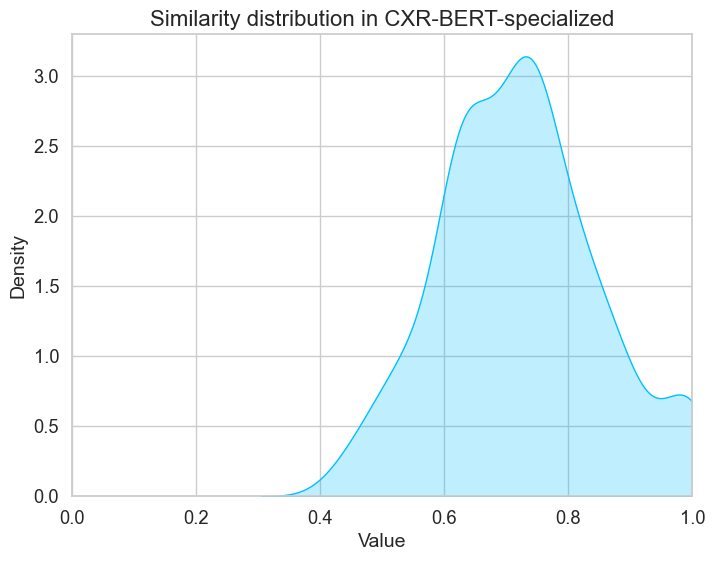

In [17]:
cosine_sim_matrix = cosine_similarity(cls_embeddings.detach().cpu().numpy() )
plot_heat(cosine_sim_matrix, "CXR-BERT-specialized", True)
plot_dis(cosine_sim_matrix, "CXR-BERT-specialized")

CXR_Bert_specialized = cosine_sim_matrix.flatten()

In [18]:
model_name = "microsoft/BiomedVLP-CXR-BERT-specialized"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# 定义输入文本列表
text_list = CheXpert_prompt
# 使用tokenizer对文本进行处理，确保扁平化的输入列表
inputs = tokenizer(text_list, padding=True, truncation=True, return_tensors="pt")

# 推理模型，获取输出
with torch.no_grad():
    outputs = model(**inputs)

# 提取CLS token的输出作为句子的embedding表示
CheXpert_CXR_BERT_specialized_embedding = outputs.last_hidden_state[:, 0, :]


text_list = NIH_prompt
# 使用tokenizer对文本进行处理，确保扁平化的输入列表
inputs = tokenizer(text_list, padding=True, truncation=True, return_tensors="pt")

# 推理模型，获取输出
with torch.no_grad():
    outputs = model(**inputs)

NIH_CXR_BERT_specialized_embedding = outputs.last_hidden_state[:, 0, :]


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'CXRBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type cxr-bert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertModel were not initialized from the model checkpoint at microsoft/BiomedVLP-CXR-BERT-specialized and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [19]:
CheXpert_CXR_BERT_specialized_embedding.shape

torch.Size([13, 768])

## BioViL-T

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Embedding for sentence 1:
Embedding for sentence 2:
Embedding for sentence 3:
Embedding for sentence 4:
Embedding for sentence 5:
Embedding for sentence 6:
Embedding for sentence 7:
Embedding for sentence 8:
Embedding for sentence 9:
Embedding for sentence 10:
Embedding for sentence 11:
Embedding for sentence 12:
Embedding for sentence 13:
Embedding for sentence 14:
Embedding for sentence 15:
Embedding for sentence 16:
Embedding for sentence 17:
Embedding for sentence 18:
Embedding for sentence 19:
Embedding for sentence 20:
Embedding for sentence 21:


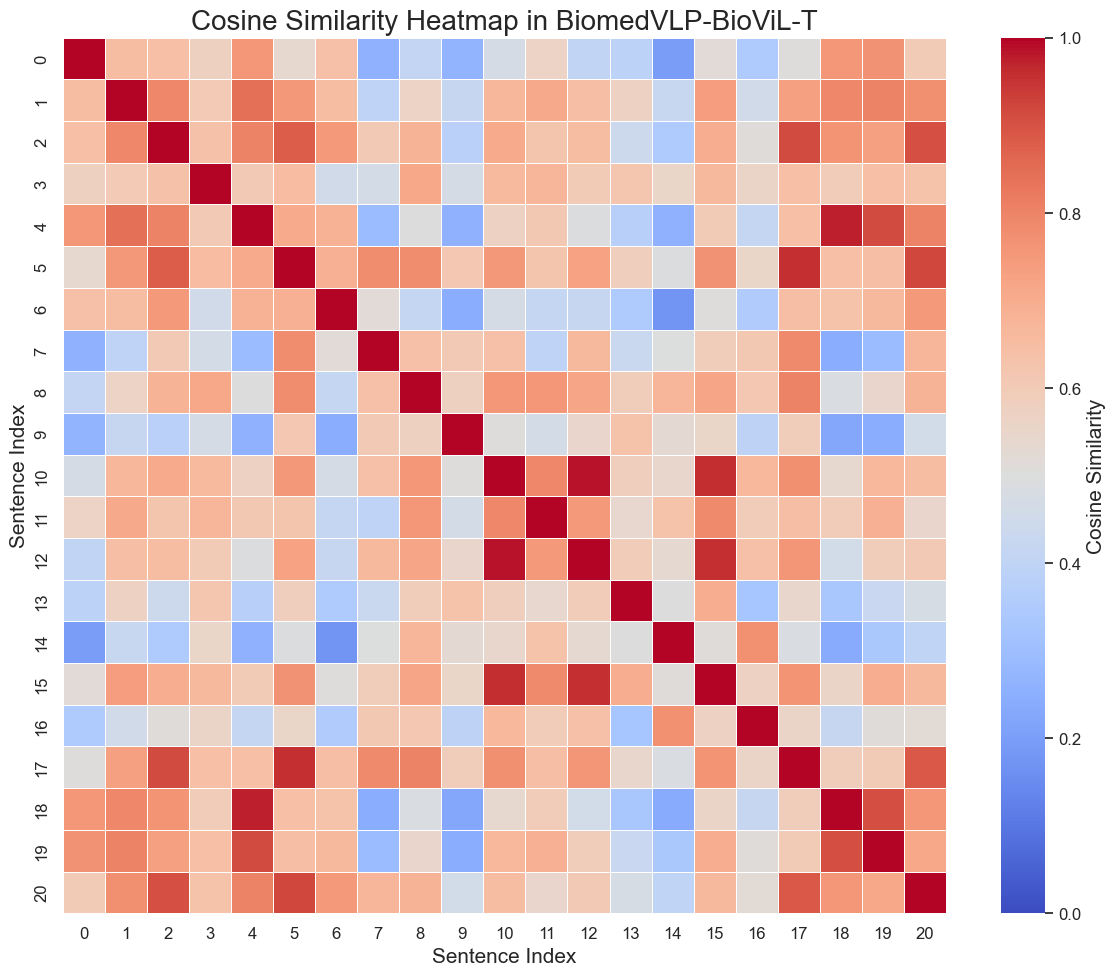

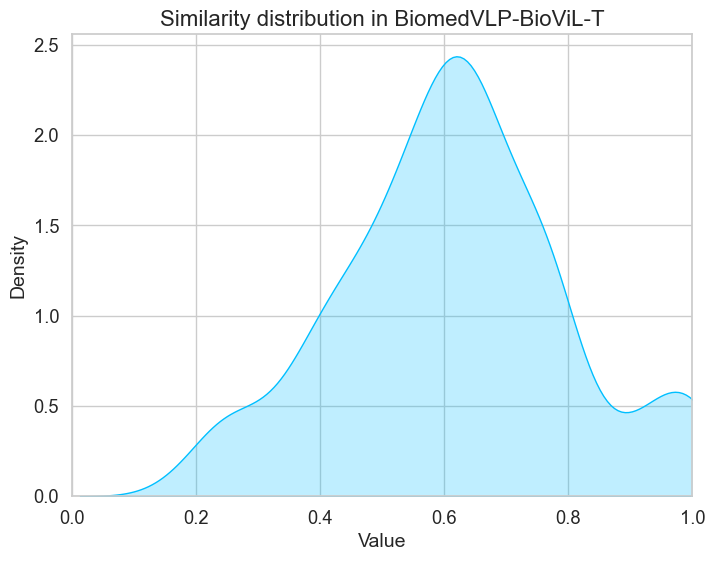

In [20]:

model_name = "microsoft/BiomedVLP-BioViL-T"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# 定义输入文本列表
text_list = text_4_clip
# 使用tokenizer对文本进行处理，确保扁平化的输入列表
inputs = tokenizer(text_list, padding=True, truncation=True, return_tensors="pt")

# 推理模型，获取输出
with torch.no_grad():
    outputs = model(**inputs)

# 提取CLS token的输出作为句子的embedding表示
cls_embeddings = outputs.last_hidden_state[:, 0, :]

# 打印每个句子的embedding表示
for i, embedding in enumerate(cls_embeddings):
    print(f"Embedding for sentence {i+1}:")
cosine_sim_matrix = cosine_similarity(cls_embeddings.detach().cpu().numpy() )
plot_heat(cosine_sim_matrix, "BiomedVLP-BioViL-T", True)
plot_dis(cosine_sim_matrix, "BiomedVLP-BioViL-T")
BiomedVLP_BioViL_T = cosine_sim_matrix.flatten()

## BioBert

In [21]:
from transformers import AutoTokenizer, AutoModel
import torch

# 加载BioBERT模型和分词器
model_name = "dmis-lab/biobert-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# 示例句子列表
sentences = text_4_clip

# 编码句子
inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)

# 通过BioBERT模型进行前向传播，提取所有层的输出
with torch.no_grad():
    outputs = model(**inputs)

# 获取最后一层隐藏状态
last_hidden_states = outputs.last_hidden_state

# 平均池化每个句子的嵌入（或选择 [CLS] 标记的嵌入）
sentence_embeddings = last_hidden_states.mean(dim=1).squeeze().numpy()

# 打印句子嵌入的形状
print("Shape of sentence embeddings:", sentence_embeddings.shape)


Shape of sentence embeddings: (21, 768)


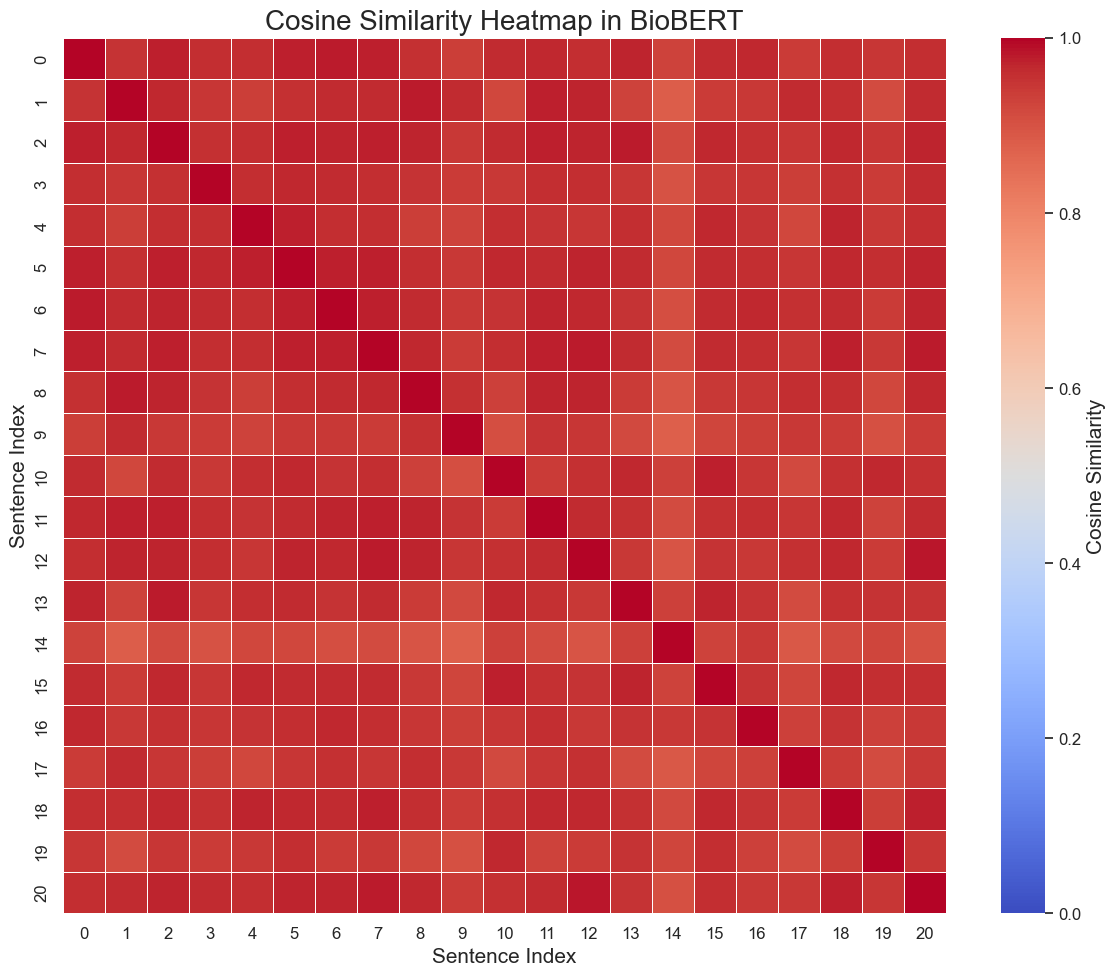

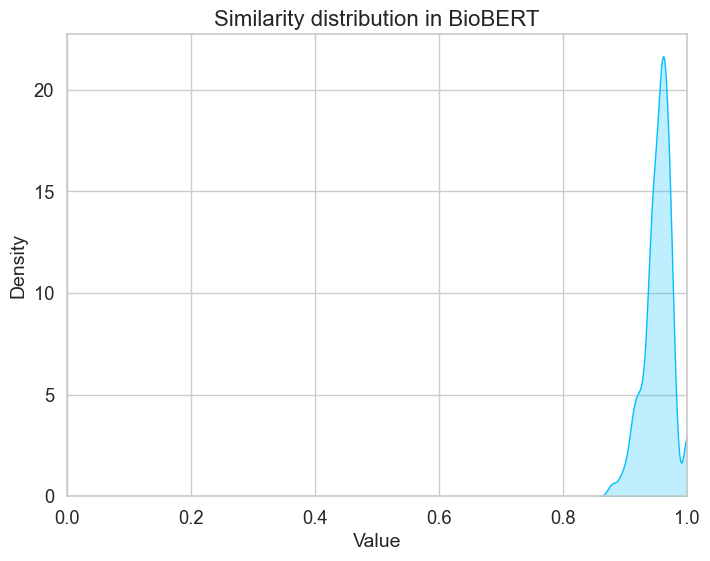

In [22]:
cosine_sim_matrix = cosine_similarity(sentence_embeddings)
plot_heat(cosine_sim_matrix, "BioBERT",True)
plot_dis(cosine_sim_matrix, "BioBERT")
biobert = cosine_sim_matrix.flatten()

## Bert

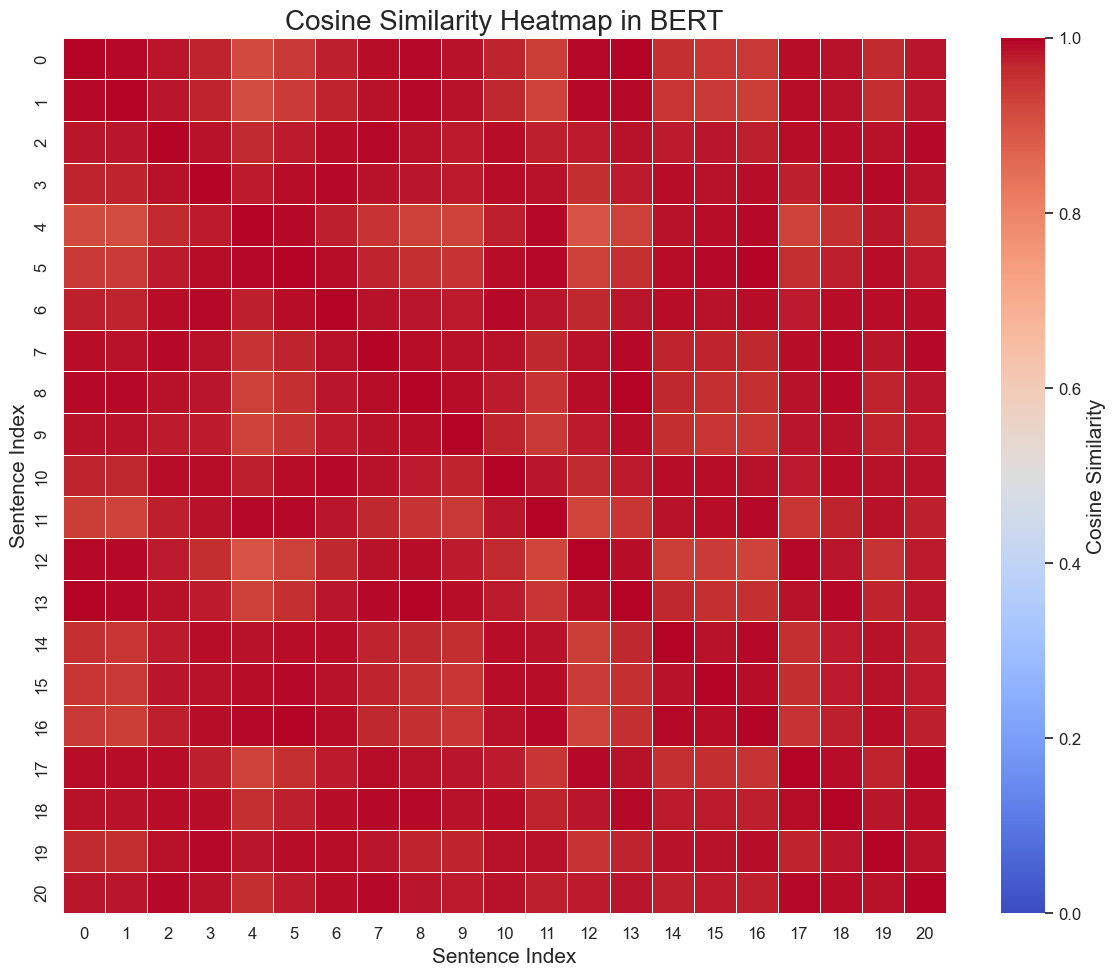

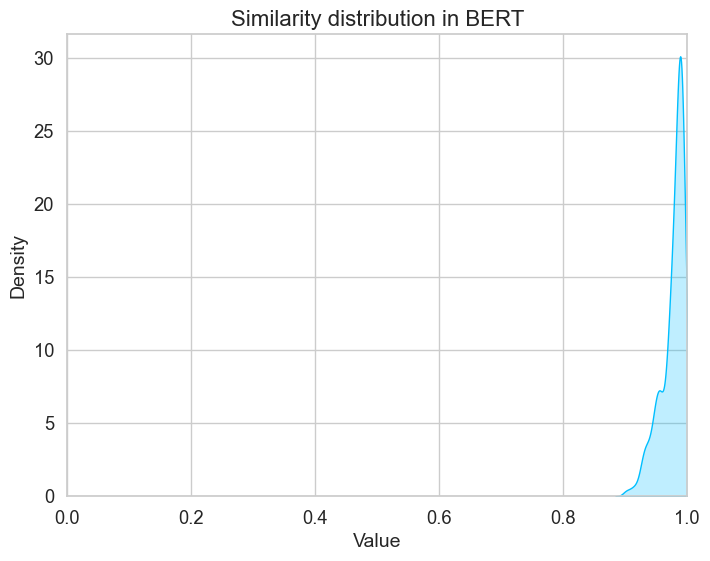

In [23]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")
with torch.no_grad():
  encoded_input = tokenizer(text_4_clip, return_tensors='pt', padding=True)
  output = model(**encoded_input)
cls_embedding = (output.pooler_output)
cosine_sim_matrix = cosine_similarity(cls_embedding)
plot_heat(cosine_sim_matrix, "BERT", True)
plot_dis(cosine_sim_matrix, "BERT")
bert = cosine_sim_matrix.flatten()

In [24]:
text_4_clip

['it is a image of Emphysema',
 'it is a image of Mass',
 'it is a image of Pneumonia',
 'it is a image of Fracture',
 'it is a image of Lung Lesion',
 'it is a image of Lung Opacity',
 'it is a image of Fibrosis',
 'it is a image of Edema',
 'it is a image of Atelectasis',
 'it is a image of Support Devices',
 'it is a image of Pleural Effusion',
 'it is a image of Hernia',
 'it is a image of Effusion',
 'it is a image of Pneumothorax',
 'it is a image of Enlarged Cardiomediastinum',
 'it is a image of Pleural Other',
 'it is a image of Cardiomegaly',
 'it is a image of Consolidation',
 'it is a image of Nodule',
 'it is a image of Pleural_Thickening',
 'it is a image of Infiltration']

---
## Save embedding tensor

In [ ]:
import torch
# 保存到 .pt 文件
torch.save({
    'NIH_CLIP': NIH_CLIP_embedding,
    'CheXpert_CLIP': CheXpert_CLIP_embedding,
    'NIH_BiomedCLIP': NIH_BiomedCLIP_embedding,
    "CheXpert_BiomedCLIP": CheXpert_BiomedCLIP_embedding,
    "NIH_CXR-BERT-specialized": NIH_CXR_BERT_specialized_embedding,
    "CheXpert_CXR-BERT-specialized": CheXpert_CXR_BERT_specialized_embedding,
}, 'D:\FGA\data\prompt_embeddings.pt')

print("Embeddings have been saved to embeddings.pt")

In [ ]:
import torch

# 从 .pt 文件加载
loaded_data = torch.load(r'D:\FGA\data\prompt_embeddings.pt')
for i in loaded_data:
    print(i, loaded_data[i].shape)
    
# NIH_CLIP  = loaded_data['CheXpert_BiomedCLIP']    
# print(NIH_CLIP.shape)


NIH_CLIP torch.Size([14, 512])
CheXpert_CLIP torch.Size([13, 512])
NIH_BiomedCLIP torch.Size([14, 512])
CheXpert_BiomedCLIP torch.Size([13, 512])
NIH_CXR-BERT-specialized torch.Size([14, 768])
CheXpert_CXR-BERT-specialized torch.Size([13, 768])


---
## 数据分布可视化对比
### 山脊图

In [80]:
embedding_sim = {"bert": bert, "biobert": biobert, "BiomedVLP_BioViL_T": BiomedVLP_BioViL_T, "CXR_Bert_specialized": CXR_Bert_specialized, "CXR_Bert_general": CXR_Bert_general, "CLIP": CLIP, "BiomedCLIP": BiomedCLIP}
embedding_sim = {"BiomedVLP_BioViL_T": BiomedVLP_BioViL_T, 
                 "CXR_Bert_specialized": CXR_Bert_specialized,
                 "BiomedCLIP": BiomedCLIP, 
                 "CLIP": CLIP, 
                 "CXR_Bert_general": CXR_Bert_general,
                 "BioBert": biobert,
                 "Bert": bert, }
data =  embedding_sim

In [77]:
embedding_sim_paper = {
  # "BiomedVLP_BioViL_T": BiomedVLP_BioViL_T, 
  "CXR_Bert_specialized": CXR_Bert_specialized,
  "BiomedCLIP": BiomedCLIP,
  #  "CLIP": CLIP, 
  # "CXR_Bert_general": CXR_Bert_general,
  "BioBert": biobert,
  # "Bert": bert, 
  }

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei"]  # 显示中文
plt.rcParams["axes.unicode_minus"] = False  # 显示负号

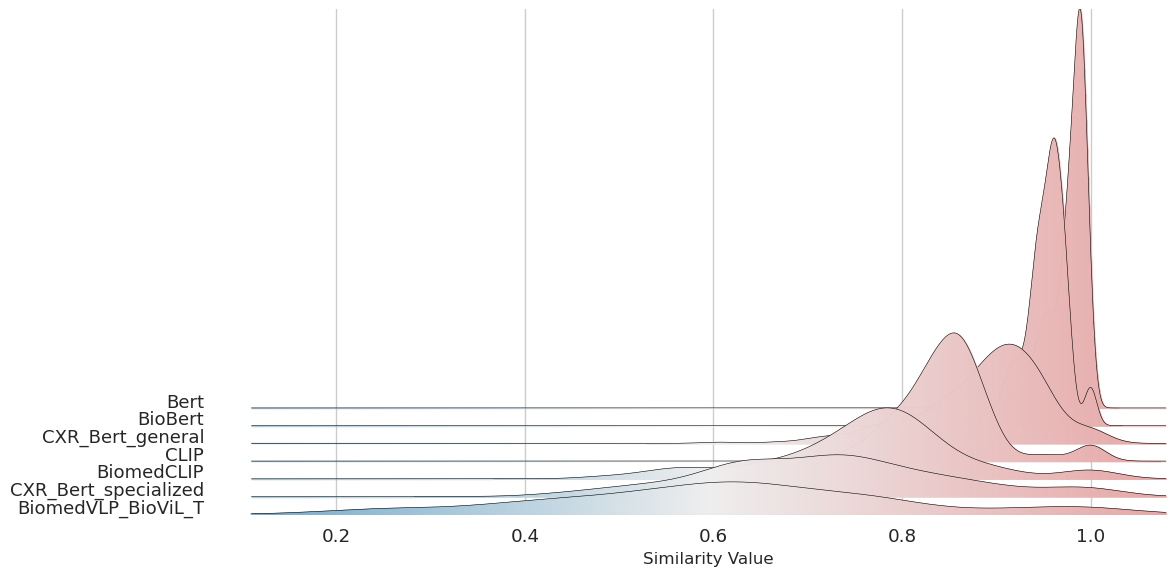

In [83]:

# 创建5个分布的数据
# data = {
#     "CXR_Bert": np.random.beta(5, 2, 1000),
#     "BioClinicalBERT": np.random.normal(0.4, 0.1, 1000),
#     "PubMedBERT": np.random.normal(0.6, 0.1, 1000),
#     "BlueBERT": np.random.normal(0.8, 0.1, 1000),
#     "SpecialCMT": np.random.normal(1.0, 0.1, 1000)
# }

# 可配置参数
step_z = 0.2  # 控制峰态的视觉高度
x_limit = [0.11, 1.08]  # x 轴范围
colors = ["#71aacc", "#eeeeee", "#e6a6a5"]  # 设置渐变填充色
cmap = LinearSegmentedColormap.from_list("custom_red_blue", colors)
step_size = 1  # 设置步长，控制渐变色填充的梯度

# 绘制图形
fig, ax = plt.subplots(figsize=(12, 6))
# ax.set_title("Distribution Shift", fontsize=16)

for i, (label, values) in enumerate(data.items()):
    # 计算每组数据的密度估计
    kde = gaussian_kde(values)
    x = np.linspace(*x_limit, 1000)
    y = kde(x)
    # 使用渐变色填充
    z = i * step_z
    norm = plt.Normalize(x.min(), x.max())
    for j in range(0, len(x) - 1, step_size):
        ax.fill_between(
            x[j : j + step_size + 1],
            z + y[j : j + step_size + 1] * 0.15,  # 缩小y轴范围
            z,
            color=cmap(norm(x[j])),
            alpha=0.7,  # 增加透明度
            zorder=(len(data) - i) + 1,
        )
    # 绘制曲线
    ax.plot(x, i * step_z + y * 0.15, color="#000", linewidth=0.4,
            zorder=len(data) - i + 1)
    # 绘制纵轴刻度标签
    ax.text(x_limit[0] - 0.05, i * step_z + 0.07, label, ha="right", va="center", fontsize=13)

# 修饰绘图细节
ax.set_yticks([])  # 移除 y 轴刻度
ax.set_yticklabels([])
ax.spines["left"].set_visible(False)  # 移除边框
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim(*x_limit)  # 设置 x 轴范围
ax.set_ylim(0, (len(data) - 1) * step_z + 4.5)  # 设置 y 轴范围
ax.set_xlabel("Similarity Value", fontsize=12)

plt.tight_layout()
plt.savefig("distribution_shift.png", dpi=600)
plt.show()

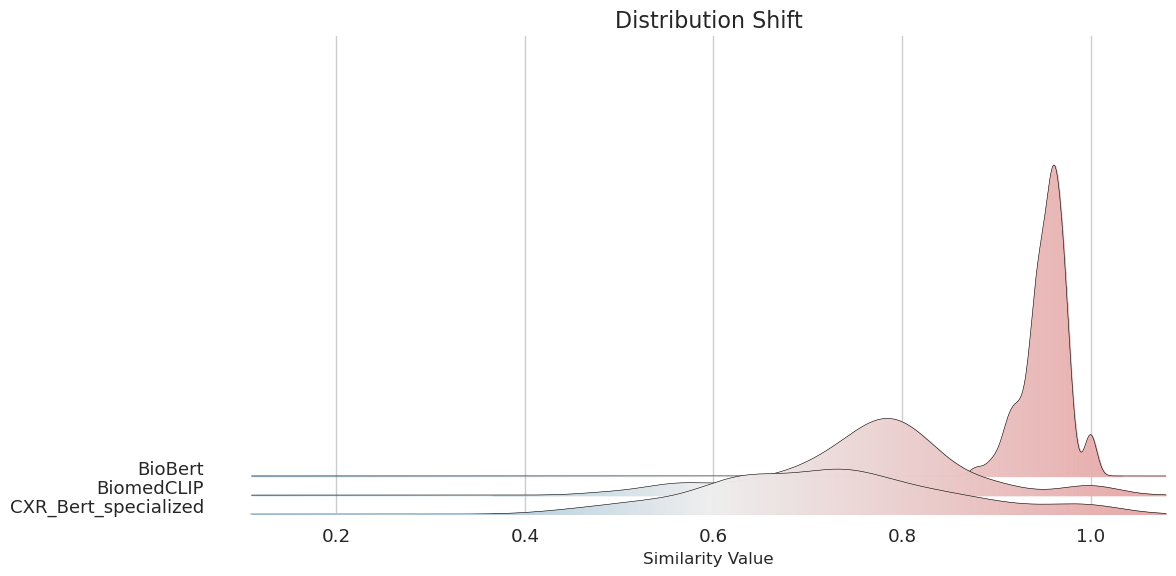

In [78]:
data = embedding_sim_paper

# 创建5个分布的数据
# data = {
#     "CXR_Bert": np.random.beta(5, 2, 1000),
#     "BioClinicalBERT": np.random.normal(0.4, 0.1, 1000),
#     "PubMedBERT": np.random.normal(0.6, 0.1, 1000),
#     "BlueBERT": np.random.normal(0.8, 0.1, 1000),
#     "SpecialCMT": np.random.normal(1.0, 0.1, 1000)
# }

# 可配置参数
step_z = 0.2  # 控制峰态的视觉高度
x_limit = [0.11, 1.08]  # x 轴范围
colors = ["#71aacc", "#eeeeee", "#e6a6a5"]  # 设置渐变填充色
cmap = LinearSegmentedColormap.from_list("custom_red_blue", colors)
step_size = 1  # 设置步长，控制渐变色填充的梯度

# 绘制图形
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Distribution Shift", fontsize=16)

for i, (label, values) in enumerate(data.items()):
    # 计算每组数据的密度估计
    kde = gaussian_kde(values)
    x = np.linspace(*x_limit, 1000)
    y = kde(x)
    # 使用渐变色填充
    z = i * step_z
    norm = plt.Normalize(x.min(), x.max())
    for j in range(0, len(x) - 1, step_size):
        ax.fill_between(
            x[j : j + step_size + 1],
            z + y[j : j + step_size + 1] * 0.15,  # 缩小y轴范围
            z,
            color=cmap(norm(x[j])),
            alpha=0.7,  # 增加透明度
            zorder=(len(data) - i) + 1,
        )
    # 绘制曲线
    ax.plot(x, i * step_z + y * 0.15, color="#000", linewidth=0.4,
            zorder=len(data) - i + 1)
    # 绘制纵轴刻度标签
    ax.text(x_limit[0] - 0.05, i * step_z + 0.07, label, ha="right", va="center", fontsize=13)

# 修饰绘图细节
ax.set_yticks([])  # 移除 y 轴刻度
ax.set_yticklabels([])
ax.spines["left"].set_visible(False)  # 移除边框
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim(*x_limit)  # 设置 x 轴范围
ax.set_ylim(0, (len(data) - 1) * step_z + 4.6)  # 设置 y 轴范围
ax.set_xlabel("Similarity Value", fontsize=12)

plt.tight_layout()
plt.savefig("Paper_distribution_shift.png", dpi=600)
plt.show()


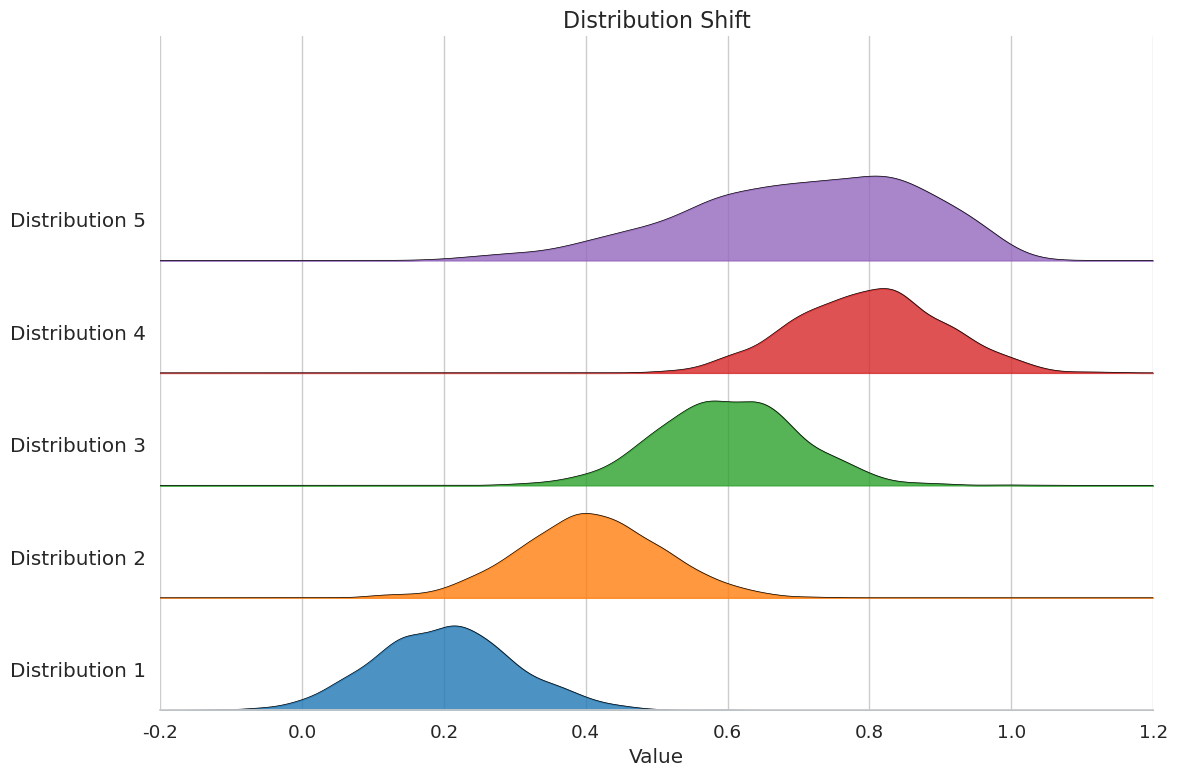

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 生成5个分布的数据
np.random.seed(42)
distributions = [
    np.random.normal(loc=0.2, scale=0.1, size=1000),
    np.random.normal(loc=0.4, scale=0.1, size=1000),
    np.random.normal(loc=0.6, scale=0.1, size=1000),
    np.random.normal(loc=0.8, scale=0.1, size=1000),
    np.random.beta(a=5, b=2, size=1000)
]

labels = ['Distribution 1', 'Distribution 2', 'Distribution 3', 'Distribution 4', 'Distribution 5']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig, ax = plt.subplots(figsize=(12, 8))

x_range = np.linspace(-0.2, 1.2, 1000)
for i, (dist, label, color) in enumerate(zip(distributions, labels, colors)):
    kde = gaussian_kde(dist)
    y = kde(x_range)
    ax.fill_between(x_range, i*0.2 + y/y.max()*0.15, i*0.2, alpha=0.8, color=color, label=label)
    ax.plot(x_range, i*0.2 + y/y.max()*0.15, color='black', linewidth=0.5)

ax.set_ylim(0, 1.2)
ax.set_xlim(-0.2, 1.2)
ax.set_yticks([])
ax.set_xlabel('Value')
ax.set_title('Distribution Shift', fontsize=16)

# 添加分布标签
for i, label in enumerate(labels):
    ax.text(-0.22, i*0.2 + 0.07, label, ha='right', va='center')

# 移除顶部和右侧边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 23665 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 33034 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32447 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 22270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 23665 missing from curren

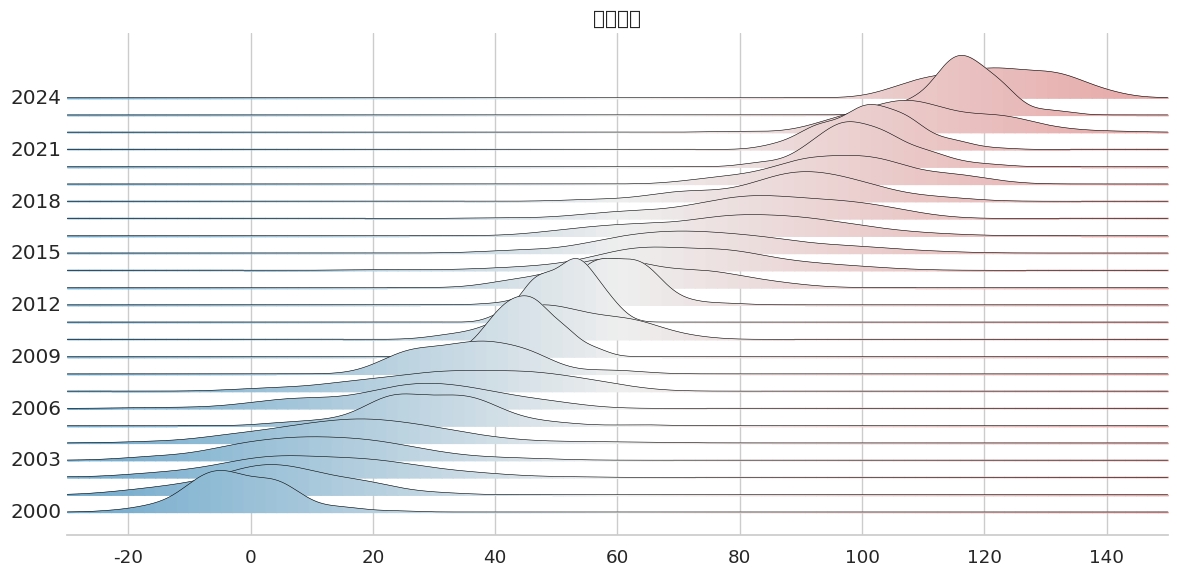

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams["font.sans-serif"] = ["Microsoft YaHei"]  # 显示中文
plt.rcParams["axes.unicode_minus"] = False  # 显示负号

## 创建数据集（可通过 print 查看数据集格式）
data = {}

for i in range(25):
    loc = np.random.uniform(2, 8)  # 生成随机均值
    scale = np.random.uniform(5, 15)  # 生成随机标准差
    data[str(i + 2000)] = np.random.normal(5 * (i - 1) + loc, scale, 100)

## 可配置参数
step_z = 0.02  # 控制峰态的视觉高度，根据数据规模调整到合理值
x_limit = [-30, 150]  # x 轴范围
colors = ["#71aacc", "#eeeeee", "#e6a6a5"]  # 设置渐变填充色
cmap = LinearSegmentedColormap.from_list("custom_red_blue", colors)
step_size = 10  # 设置步长，控制渐变色填充的梯度

## 绘制图形
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("山脊线图")

for i, (label, values) in enumerate(data.items()):
    # 计算每组数据的密度估计
    kde = gaussian_kde(values)
    x = np.linspace(*x_limit, 1000)
    y = kde(x)
    # 使用渐变色填充
    z = i * step_z
    norm = plt.Normalize(x.min(), x.max())
    for j in range(0, len(x) - 1, step_size):
        ax.fill_between(
            x[j : j + step_size + 1],
            z + y[j : j + step_size + 1],
            z,
            color=cmap(norm(x[j])),
            zorder=(len(data) - i) + 1,
        )
    # 绘制曲线
    ax.plot(x, i * step_z + y, color="#000", linewidth=0.4,
            zorder=len(data) - i + 1)
    # 绘制纵轴刻度标签
    if i % 3 == 0:  # 隔 3 组绘制 1 组
        ax.text(x_limit[0] - 1, i * step_z, label, ha="right", va="center")

## 修饰绘图细节
ax.set_yticks([])  # 移除 y 轴刻度
ax.set_yticklabels([])
ax.spines["left"].set_visible(False)  # 移除边框
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim(*x_limit)  # 设置 x 轴范围
plt.tight_layout()
plt.show()